# OpenJij SA Parameter Dependency Experiment with MINTO

ここでは、OpenJijのシミュレーテッドアニーリング(SA)アルゴリズムのパラメータが、SAのパフォーマンスにどう影響を与えるかを簡単に調べてみます。
SAアルゴリズムは温度をパラメータとして持ち、OpenJijではQUBOもしくはIsing模型の係数をベースに温度を自動で設定します。
グリッドサーチを用いて、このパラメータの自動設定の有効性を調べてみましょう。
グリッドサーチの場合でも、`MINTO`をログ記録として利用すれば、データを`pandas.DataFrame`に簡単に変換し可視化することができます。
これにより、様々なパラメータの組合せと、それらが解の品質や実行時間に与える影響を分析することが可能です。

<!-- This notebook is a simple experiment to see how the parameters of the Simulated Annealing (SA) algorithm in OpenJij affect the performance of the algorithm.  

The SA algorithm has temperature as a parameter, and OpenJij automatically sets this temperature based on the coefficients of QUBO or Ising models. Let's verify how effective these automatic parameter settings are by using grid search.

Even in grid search cases, using MINTO for logging allows us to easily convert the data to pandas.DataFrame for visualization. This helps us analyze the relationship between different parameter combinations and their impact on solution quality and execution time. -->

In [1]:
import openjij as oj
import numpy as np
import minto
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Create Random QUBO

In [2]:
def random_qubo(n, sparsity=0.5):
    q = np.random.uniform(-1, 1, (n, n))
    q = (q + q.T) / 2
    zero_num = int(n**2 * sparsity)
    zero_i = np.random.choice(n, zero_num, replace=True)
    zero_j = np.random.choice(n, zero_num, replace=True)
    q[zero_i, zero_j] = 0
    q[zero_j, zero_i] = 0
    qubo = {}
    for i in range(n-1):
        for j in range(i, n):
            qubo[(i, j)] = q[i, j]
            qubo[(j, i)] = q[j, i]
    return qubo


In [3]:
n = 200
q = random_qubo(n)

## 2. デフォルトの設定で実行する

OpenJijでは、`.sample_qubo`の戻り値の中にある`.info['schedule']`を通して、自動で決定されたSAパラメータを確認することができます。
SAの温度設定はアニーリングスケジュールと呼ばれ、これらのパラメータは'schedule'のキーの下に保存されます。

<!-- ## 2. Run with default parameters

In OpenJij, you can check the automatically configured SA parameters through `.info['schedule']` in the return value of `.sample_qubo`. These parameters are stored under the key 'schedule' since the temperature settings in SA are referred to as the annealing schedule. -->

In [4]:
sampler = oj.SASampler()
response = sampler.sample_qubo(q)
schedule = response.info["schedule"]
schedule

{'beta_max': 4274.216268569347,
 'beta_min': 0.19943913796088258,
 'num_sweeps': 1000}

## MINTOを用いたグリッドサーチ

SAの逆温度パラメータを変化させることで、最適化結果がどのように変わるかを見てみましょう。
比較のために、OpenJijのデフォルトのパラメータも検索範囲に含めておきます。
OpenJijの結果から重要な値は、`.log_parameter`メソッドを用いて保存されます。
完全なOpenJijのresponseオブジェクトも、`.to_serializable`を指定した`.log_object`を用いて保存されます。

<!-- ## 3. Grid search with MINTO

Let's see how the optimization results change by varying the inverse temperature parameters of SA. We'll include OpenJij's default parameters in our search range for comparison.

The important values from OpenJij's results are stored using `.log_parameter` method. The complete OpenJij response object is also saved using `.log_object` method with `.to_serializable`. -->

In [5]:
exp = minto.Experiment(auto_saving=False, verbose_logging=False)

# log_object accepts only serializable objects
# so we need to convert qubo to serializable object
qubo_edges = [[i, j] for i, j in q.keys()]
qubo_vales = [q[i, j] for i, j in qubo_edges]
exp.log_global_object("qubo", {"qubo_edges": qubo_edges, "qubo_vales": qubo_vales})

beta_min_list = [schedule["beta_min"], 0.1, 1.0, 2.0, 3.0, 4.0, 5.0]
beta_max_list = [10.0, 20, 30.0, 40.0, 50.0, 12404, schedule["beta_max"]]
num_reads = 300

exp.log_global_parameter("num_reads", num_reads)

for beta_min in beta_min_list:
    for beta_max in beta_max_list:
        run = exp.run()
        with run:
            # Log the beta parameters for this run
            run.log_parameter("beta_min", beta_min)
            run.log_parameter("beta_max", beta_max)

            sampler = oj.SASampler()
            response = exp.log_solver(sampler.sample_qubo)(q, num_reads=num_reads, beta_min=beta_min, beta_max=beta_max)
            run.log_object("response", response.to_serializable())
            energies = response.energies
            run.log_parameter("mean_energy", np.mean(energies))
            run.log_parameter("std_energy", np.std(energies))
            run.log_parameter("min_energy", np.min(energies))
            run.log_parameter("exec_time", response.info["execution_time"])

In [6]:
run_table = exp.get_run_table()
run_table

parameter                                                              \
        beta_min      beta_max  solver_name num_reads mean_energy std_energy   
run_id                                                                         
0       0.199439     10.000000  sample_qubo       300 -369.642340   0.963114   
1       0.199439     20.000000  sample_qubo       300 -369.613328   0.999489   
2       0.199439     30.000000  sample_qubo       300 -369.537418   1.073169   
3       0.199439     40.000000  sample_qubo       300 -369.672725   1.013148   
4       0.199439     50.000000  sample_qubo       300 -369.535609   1.081694   
5       0.199439  12404.000000  sample_qubo       300 -369.404223   1.182786   
6       0.199439   4274.216269  sample_qubo       300 -369.447492   1.059979   
7       0.100000     10.000000  sample_qubo       300 -369.526662   1.020109   
8       0.100000     20.000000  sample_qubo       300 -369.546022   1.063859   
9       0.100000     30.000000  sample_qubo       300 -369.607539   1.050563   
10      0.100000     40.000000  sample_qubo       300 -369.643295   1.016970   
11      0.100000     50.000000  sample_qubo       300 -369.603176   1.025462   
12      0.100000  12404.000000  sample_qubo       300 -369.400657   1.108009   
13      0.100000   4274.216269  sample_qubo       300 -369.430557   1.092600   
14      1.000000     10.000000  sample_qubo       300 -369.698762   0.925739   
15      1.000000     20.000000  sample_qubo       300 -369.607248   1.023604   
16      1.000000     30.000000  sample_qubo       300 -369.707480   0.979563   
17      1.000000     40.000000  sample_qubo       300 -369.627673   1.044668   
18      1.000000     50.000000  sample_qubo       300 -369.499219   1.088815   
19      1.000000  12404.000000  sample_qubo       300 -369.369871   1.113930   
20      1.000000   4274.216269  sample_qubo       300 -369.479161   1.074741   
21      2.000000     10.000000  sample_qubo       300 -369.316021   1.092758   
22      2.000000     20.000000  sample_qubo       300 -369.292811   1.175131   
23      2.000000     30.000000  sample_qubo       300 -369.278594   1.189824   
24      2.000000     40.000000  sample_qubo       300 -369.214526   1.157426   
25      2.000000     50.000000  sample_qubo       300 -369.325817   1.105511   
26      2.000000  12404.000000  sample_qubo       300 -368.872647   1.452835   
27      2.000000   4274.216269  sample_qubo       300 -368.858743   1.323323   
28      3.000000     10.000000  sample_qubo       300 -368.996994   1.258217   
29      3.000000     20.000000  sample_qubo       300 -368.860823   1.294394   
30      3.000000     30.000000  sample_qubo       300 -368.632845   1.590694   
31      3.000000     40.000000  sample_qubo       300 -368.667235   1.436215   
32      3.000000     50.000000  sample_qubo       300 -368.493427   1.667043   
33      3.000000  12404.000000  sample_qubo       300 -367.923403   2.303434   
34      3.000000   4274.216269  sample_qubo       300 -367.960931   2.214097   
35      4.000000     10.000000  sample_qubo       300 -368.261301   1.716965   
36      4.000000     20.000000  sample_qubo       300 -368.055285   1.916874   
37      4.000000     30.000000  sample_qubo       300 -367.872730   2.261690   
38      4.000000     40.000000  sample_qubo       300 -367.735213   2.097804   
39      4.000000     50.000000  sample_qubo       300 -367.677898   2.196177   
40      4.000000  12404.000000  sample_qubo       300 -366.455199   3.236642   
41      4.000000   4274.216269  sample_qubo       300 -366.756632   2.963267   
42      5.000000     10.000000  sample_qubo       300 -367.586018   2.431858   
43      5.000000     20.000000  sample_qubo       300 -367.349294   2.555882   
44      5.000000     30.000000  sample_qubo       300 -367.077661   2.775944   
45      5.000000     40.000000  sample_qubo       300 -367.292769   2.675066   
46      5.000000     50.000000  sample_qubo       300 -367.020018   2.771812   
47     

## 4. 結果の可視化

`pivot`メソッドをしようし、`run_table`をヒートマップでの可視化に適した形式に変換しましょう。
`MINTO`の`.get_run_table()`は二重ヘッダーを持つDataFrameを返します。
そのため、関連するDaFrameを抽出するために`parameter`キーを使用し、得られたものをヒートマップで可視化するために変換します。

<!-- ## 4. Visualizing the results

Convert the `run_table` to a format suitable for heatmap visualization using pivot method.

MINTO's `.get_run_table()` returns a DataFrame with double-header, so we use `'parameter'` key
to extract the relevant DataFrame and then transform it for heatmap visualization. -->

In [7]:
param_table = run_table["parameter"].pivot(index="beta_min", columns="beta_max", values="mean_energy")
param_table

beta_max,10.000000,20.000000,30.000000,40.000000,50.000000,4274.216269,12404.000000
beta_min,,,,,,,
0.100000,-369.526662,-369.546022,-369.607539,-369.643295,-369.603176,-369.430557,-369.400657
0.199439,-369.642340,-369.613328,-369.537418,-369.672725,-369.535609,-369.447492,-369.404223
1.000000,-369.698762,-369.607248,-369.707480,-369.627673,-369.499219,-369.479161,-369.369871
2.000000,-369.316021,-369.292811,-369.278594,-369.214526,-369.325817,-368.858743,-368.872647
3.000000,-368.996994,-368.860823,-368.632845,-368.667235,-368.493427,-367.960931,-367.923403
4.000000,-368.261301,-368.055285,-367.872730,-367.735213,-367.677898,-366.756632,-366.455199
5.000000,-367.586018,-367.349294,-367.077661,-367.292769,-367.020018,-366.356028,-366.328475


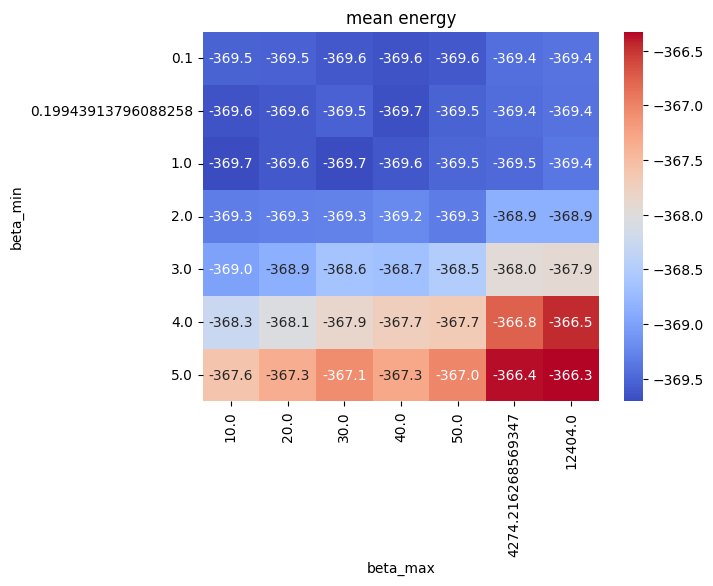

In [8]:
sns.heatmap(param_table, annot=True, fmt="1.1f", cmap="coolwarm")
plt.xlabel("beta_max")
plt.ylabel("beta_min")
plt.title("mean energy")
plt.show()

## 5. 結果の解析

この結果を見ると、OpenJijのデフォルトのパラメータは悪くありません。
しかし、`beta_max=40.0, beta_min=0.1`付近でより最適なパラメータがあるように見えます。
別の視点から見てみましょう。
OpenJijのアルゴリズムでは、スピンフリップが拒否された場合、その計算は行われません。
スピンフリップが発生した場合には、そのエネルギー差を計算します。
そのため、温度が高い(逆温度$\beta$が低い)状態が長期間続くと、スピンフリップ回数が増加し、計算時間が長くなります。  
結果として、温度設定に依存して計算時間が変化します。
これらの結果を可視化してみましょう。
OpenJijの計算時間は、マイクロ秒単位で測定されています。

<!-- ## 5. Result Analysis

Looking at the results, OpenJij's default parameters are not bad, but there appears to be more optimal parameters around `beta_max=40.0, beta_min=0.1`.

Let's examine another perspective. In OpenJij's algorithm, when a spin flip is rejected, no calculation is performed. When a spin flip occurs, the energy difference is calculated. Therefore, if the temperature is high (inverse temperature beta is low) for a long period, the number of spin flips increases, leading to increased computation time.

As a result, the computation time varies depending on the temperature settings. Let's visualize these results. OpenJij's computation time is measured in microseconds. -->

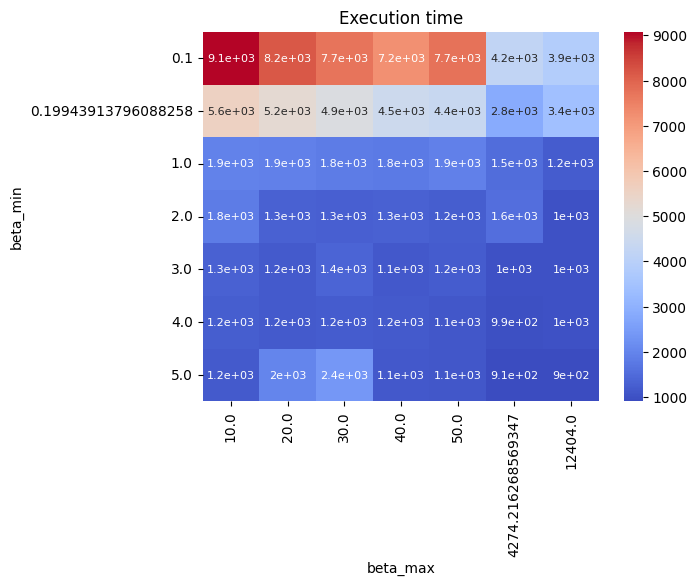

In [9]:
exec_table = run_table["parameter"].pivot(
    index="beta_min", columns="beta_max", values="exec_time"
)
sns.heatmap(exec_table, annot=True, cmap="coolwarm", annot_kws={"size": 8})
plt.xlabel("beta_max")
plt.ylabel("beta_min")
plt.title("Execution time")
plt.show()

# OpenJijのデフォルトのパラメータについての解析

残念なことに、OpenJij のデフォルトのパラメータは、計算時間の点で最適ではないことがわかりました。
温度パラメータは、SAのステップ数を制御する`num_sweeps`パラメータの影響も受けます。
この数値実験により、OpenJijの温度パラメータ設定には、依然として改善の余地があることが明らかとなりました。
そして`MINTO`は、ソルバーパラメータの設定に関する知見を得る上で有用であることがわかります。


<!-- # Analysis of OpenJij's Default Parameters

Unfortunately, OpenJij's default parameters appear to be suboptimal in terms of computation time.

The temperature parameters are also affected by the `num_sweeps` parameter that controls the number of steps in simulated annealing.

This numerical experiment reveals that there is still room for improvement in OpenJij's temperature parameter settings.

MINTO proves useful in gaining insights about solver parameter configurations. -->